In [1]:
from __future__ import division, print_function, absolute_import

import collections
import os, re
import random
import urllib.request
import zipfile
import pandas as pd
import itertools


import numpy as np
import tensorflow as tf

from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Phrases

In [2]:
df_rev=pd.read_csv("All_Reviews.csv")
restaurant_reviews=list(df_rev.review.values)

In [6]:

#Cleaning data - remove punctuation from every review text
texts=restaurant_reviews
sentences = []
#Remove "\n" occurring in the middle of the corpus.
sentences = [re.sub(pattern=r'\n', 
                    repl='', 
                    string=x
                   ) for x in texts]
#Remove other punctuations occurring in the corpus and tokenize (split into words) the sentences
sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                    repl='', 
                    string=x
                   ).lower().strip().split(' ') for x in sentences]
#Remove occurence of '' in the token list
for x in sentences:
    while True:
        try:
            x.remove('')  # remove first occurence of ''
        except ValueError:
            break #  no more occurence of '' in the list
texts = sentences

In [7]:
len(texts)

73676

In [8]:
#bi-gram phrasing to cluster bi-gram food name into a single name that are otherwise seperate words (currently stopping at bi-gram).
bifood_transformer = Phrases(texts, min_count=3,threshold=1,common_terms=STOP_WORDS)

In [9]:
bifood_texts=list(bifood_transformer[texts])

/opt/conda/envs/data3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:
len(bifood_texts)

73676

In [11]:
bifood_flattened_text=list(itertools.chain(*bifood_texts))

In [12]:
#total words in the corpus
len(bifood_flattened_text)

5998640

In [13]:
""" Word2Vec TensorFlow implementation
Code used from below author and modified to my dish extraction needs
Courtesy: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""

# Training Parameters
learning_rate = 0.1
batch_size = 128
num_steps = 3000000
display_step = 100000
eval_step = 200000

# Evaluation Parameters
eval_words = ['idli', 'dosa', 'pakora', 'chaat', 'bhel_puri', 'pani_puri']

# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector
max_vocabulary_size = 200000 # Total number of different words in the vocabulary
min_occurrence = 1 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 1 # How many times to reuse an input to generate a label
num_sampled = 64 # Number of negative examples to sample

text_words = bifood_flattened_text

# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break
# Compute the vocabulary size
vocabulary_size = len(count)
# Assign an id to each word
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i

data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)
id2word = dict(zip(word2id.values(), word2id.keys()))

print("Words count:", len(text_words))
print("Unique words:", len(set(text_words)))
print("Vocabulary size:", vocabulary_size)
print("Most common words:", count[:10])

Words count: 5998640
Unique words: 152343
Vocabulary size: 152344
Most common words: [('UNK', 0), ('the', 322355), ('and', 210764), ('i', 157550), ('a', 141061), ('to', 129130), ('was', 111435), ('is', 99240), ('it', 88240), ('of', 85684)]


In [ ]:

data_index = 0
# Generate training batch for the skip-gram model
def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # get window size (words left and right + current one)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


# Input data
X = tf.placeholder(tf.int32, shape=[None])
# Input label
Y = tf.placeholder(tf.int32, shape=[None, 1])

# Ensure the following ops & var are assigned on CPU
# (some ops are not compatible on GPU)
with tf.device('/cpu:0'):
    # Create the embedding variable (each row represent a word embedding vector)
    embedding = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    # Lookup the corresponding embedding vectors for each sample in X
    X_embed = tf.nn.embedding_lookup(embedding, X)

    # Construct the variables for the Neg Sampled loss
    neg_weights = tf.Variable(tf.random_normal([vocabulary_size, embedding_size]))
    neg_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average Neg Sampled loss for the batch
loss_op = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=neg_weights,
                   biases=neg_biases,
                   labels=Y,
                   inputs=X_embed,
                   num_sampled=num_sampled,
                   num_classes=vocabulary_size))

# Define the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluation
# Compute the cosine similarity between input data embedding and every embedding vectors
X_embed_norm = X_embed / tf.sqrt(tf.reduce_sum(tf.square(X_embed)))
embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
cosine_sim_op = tf.matmul(X_embed_norm, embedding_norm, transpose_b=True)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

#https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac
#we will need to store the embedding later for use.

#with tf.Session() as sess:
sess=tf.Session()

# Run the initializer
sess.run(init)

# Testing data
x_test = np.array([word2id[w] for w in eval_words])

#Start of the mini-batch runs (3 million mini-batches takes a bit of time. Repeat the below block for more runs)
average_loss = 0
for step in range(1, num_steps + 1):
    # Get a new batch of data
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    # Run training op
    _, loss = sess.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
    average_loss += loss

    if step % display_step == 0 or step == 1:
        if step > 1:
            average_loss /= display_step
        print("Step " + str(step) + ", Average Loss= " + \
              "{:.4f}".format(average_loss))
        average_loss = 0

    # Evaluation
    if step % eval_step == 0 or step == 1:
        print("Evaluation...")
        sim = sess.run(cosine_sim_op, feed_dict={X: x_test})
        for i in range(len(eval_words)):
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = '"%s" nearest neighbors:' % eval_words[i]
            for k in range(top_k):
                log_str = '%s %s,' % (log_str, id2word[nearest[k]])
            print(log_str)

Step 1, Average Loss= 20.7890
Evaluation...
"idli" nearest neighbors: restaurantsoftentimes, dinner_party, chain, goodthey, exceptionalwonderful, big_shout, hawking, burrirto,
"dosa" nearest neighbors: seekhkebabs, paneer_pakoda, 40you, tunnel, prev, good_indochinese, wireless, restaurants_we've,
"pakora" nearest neighbors: eggplant_bliss, itturned, list2, spoofeecom2, seabass, fear, affliated, delicious_middle,
"chaat" nearest neighbors: walkanddine, regs, maybethe, sourdoughnot, outlandish, babloo, worldsthe, assert,
"bhel_puri" nearest neighbors: going_to_happen, placebtw, happy_birthday, shied, brokaw_commons, fattyi, tehari, tastycarrot,
"pani_puri" nearest neighbors: restaurantsbars, standout_dishes, standardfree, locstion, fatwa, complimentarysweet, restaurantswe, samosa_filling,
Step 100000, Average Loss= 7.9335
Step 200000, Average Loss= 6.0305
Evaluation...
"idli" nearest neighbors: restaurantsoftentimes, dinner_party, chain, goodthey, exceptionalwonderful, burrirto, big_shou

Step 2300000, Average Loss= 4.4054
Step 2400000, Average Loss= 4.3881
Evaluation...
"idli" nearest neighbors: mango_lassi, excellent, dosas, dosa, yummy, perfect, also, sambar,
"dosa" nearest neighbors: sambar, dosas, veg, masala_dosa, also, veggie, the, yummy,
"pakora" nearest neighbors: mushroom, egg, crispy, spring_rolls, dry, burnt, cooked, spinach,
"chaat" nearest neighbors: their, also, amazing, the, standard, similar, usual, awesome,
"bhel_puri" nearest neighbors: ginger, puri, stuffed, naans, filter_coffee, chai, flavored, nan,
"pani_puri" nearest neighbors: samosa, which, fried, appetizer, naan, biryani, tikka, delicious,
Step 2500000, Average Loss= 4.3741
Step 2600000, Average Loss= 4.3613
Evaluation...
"idli" nearest neighbors: mango_lassi, yummy, excellent, dosas, thali, dosa, sambar, both,
"dosa" nearest neighbors: dosas, coffee, sambar, veg, masala_dosa, n, except, veggie,
"pakora" nearest neighbors: mushroom, crispy, dry, egg, spring_rolls, tasted_like, saag_paneer, stuf

In [34]:
#word_embeddings=sess.run(embedding)

In [19]:
#word_embeddings.shape
#(total vocab size, embedding dimension)

In [36]:
#save word embeddings after 3M mini-bath training runs
#np.save(open('word_embeddings_w2v_tr4_50embed_3Mruns.npy', 'wb'),word_embeddings)

In [ ]:
#save corpus vocabolary
#np.save(open('word_vocab_w2v_tr4.npy', 'wb'),word2id)

In [62]:
#load word embeddings that was saved earlier after 3M mini-batch training runs 
#embeddings_3 = np.load(open('word_embeddings_w2v_tr4_50embed_3Mruns.npy', 'rb'))

In [4]:
#read in the corpus vocabolary
#read_word_vocab_dict = np.load('word_vocab_w2v_tr4.npy').item()

In [15]:
#read in the embeddings that was stored after 12 million mini-batch runs
embeddings_12 = np.load(open('word_embeddings_w2v_tr4_50embed_12Mruns.npy', 'rb'))

In [16]:
# Input data
X = tf.placeholder(tf.int32, shape=[None])
# Input label
#Y = tf.placeholder(tf.int32, shape=[None, 1])

# Ensure the following ops & var are assigned on CPU
# (some ops are not compatible on GPU)
with tf.device('/cpu:0'):
    # Create the embedding variable (each row represent a word embedding vector)
    embedding = tf.placeholder(tf.float32,shape=[vocabulary_size, embedding_size])
    # Lookup the corresponding embedding vectors for each sample in X
    X_embed = tf.nn.embedding_lookup(embedding, X)
# Evaluation
# Compute the cosine similarity between input data embedding and every embedding vectors
X_embed_norm = X_embed / tf.sqrt(tf.reduce_sum(tf.square(X_embed)))
embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
cosine_sim_op = tf.matmul(X_embed_norm, embedding_norm, transpose_b=True)


In [17]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

#with tf.Session() as sess:
sess=tf.Session()

# Run the initializer
sess.run(init)

# Testing data
x_test = np.array([word2id[w] for w in eval_words])
#x_test = np.array([word2id[w] for w in ['chaat','idli']])

sim = sess.run(cosine_sim_op, feed_dict={X: x_test, embedding: embeddings_12})

In [19]:
for i in range(len(eval_words)):
    top_k = 20  # number of nearest neighbors
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    log_str = '"%s" nearest neighbors:' % eval_words[i]
    tmp=[]
    for k in range(top_k):
        log_str = '%s %s,' % (log_str, id2word[nearest[k]])
        tmp.append(id2word[nearest[k]])
    print(log_str)
    if eval_words[i]=='pani_puri':
        res=tmp

"idli" nearest neighbors: dosa, vada, rasam, idly, pongal, poori, tandoori, sambar, chat, rava_dosa, chai, samosa, sambhar, fry, paneer, dal, biryani, biriyani, upma, masala_dosa,
"dosa" nearest neighbors: masala_dosa, idli, biryani, idly, chaat, sambar, rasam, biriyani, pongal, samosa, vada, rava_dosa, chat, chicken_biryani, upma, chicken_65, briyani, coffee, chai, tandoori,
"pakora" nearest neighbors: aloo, dal, paneer, samosa, roti, mutton, daal, chicken_biryani, tikka, poori, chole, kofta, gobi_manchurian, puri, tandoori, fish, manchurian, chicken_65, tikka_masala, curry,
"chaat" nearest neighbors: chat, dosa, thali, biriyani, biryani, coffee, vada_pav, pav_bhaji, chai, tandoori, idli, pani_puri, veg, idly, filter_coffee, specially, samosa, briyani, chicken_biryani, dosas,
"bhel_puri" nearest neighbors: aloo_tikki, pani_puri, pav_bhaji, samosa_chaat, poori, puri, sev_puri, dahi_papdi, samosa, pakora, idli, lamb_curry, idly, rava_dosa, gobi_manchurian, tandoori, chole, kheer, masala

In [18]:
#sample 50 dimensional embedding vector for a dish-name 'idli'
embeddings_12[word2id['idli']]

array([-0.78489125, -0.2487091 ,  0.66379917,  1.1595944 , -0.29955328,
       -0.5784125 ,  1.0199845 ,  0.31168887, -0.35436767, -0.6381775 ,
       -0.03624397, -0.22175495,  0.53823435,  0.27056578,  0.16298194,
       -0.57168895,  0.23963039, -0.38119215,  0.0750663 ,  0.45919648,
        0.08113996, -0.80439305, -0.8715552 ,  0.21391077,  0.2953402 ,
        0.29765293, -0.05517034,  0.8855194 ,  0.28845087,  0.6334848 ,
        0.68480957, -0.4887037 , -0.18774432, -0.05967497,  0.76530695,
       -0.09818015,  0.00989736, -0.34408894, -0.27261785,  0.26757133,
        0.26198515,  0.4601614 , -0.41148221, -0.04470777, -0.73906994,
       -0.59477395,  0.01511358,  0.18559605,  0.01420094, -0.02512161],
      dtype=float32)

## Visualizing the word embedding's

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.cluster import KMeans
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
embeddings = np.load(open('word_embeddings_w2v_tr4_50embed_12Mruns.npy', 'rb'))

word_vocab_dict = np.load('word_vocab_w2v_tr4.npy').item()

In [5]:
def tsne_plot_kmeans_elbow_detection_plot(embed,vocab):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word,indx in vocab:
        if word not in STOP_WORDS:
            tokens.append(embed[indx])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(5, 5)) 
    inertia = []
    max_k=20
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=1).fit(new_values)
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(range(1, max_k), inertia, marker='s')
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$')


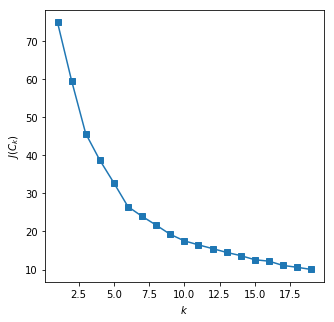

In [23]:
tsne_plot_kmeans_elbow_detection_plot(embeddings,list(word_vocab_dict.items())[0:1000])

In [6]:
#above figure shows a faint elbow at 6
num_clusters=6

In [7]:
customPalette = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

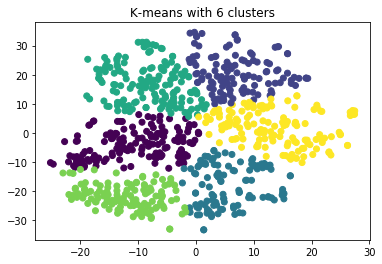

In [8]:
kmeans = KMeans(n_clusters=num_clusters, random_state=111)

labels = []
tokens = []

for word,indx in list(word_vocab_dict.items())[0:1000]:
    if word not in STOP_WORDS:
        tokens.append(embeddings[indx])
        labels.append(word)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)
kmeans.fit(new_values)

plt.title('K-means with ' + str(num_clusters) + ' clusters')
plt.scatter(new_values[:, 0], new_values[:, 1], c=kmeans.labels_)
plt.show()

In [9]:
def tsne_plot_w_clustering(embed,vocab,num_clusters=2):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word,indx in vocab:
        if word not in STOP_WORDS:
            tokens.append(embed[indx])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    kmeans = KMeans(n_clusters=num_clusters, random_state=111)
    kmeans.fit(new_values)
    

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color=customPalette[kmeans.labels_[i]])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     color=customPalette[kmeans.labels_[i]])
    #plt.scatter(x,y,c=kmeans.labels_)
    plt.savefig('tsne.png', format='png', dpi=600)    
    plt.show()
    return (labels,x,y)

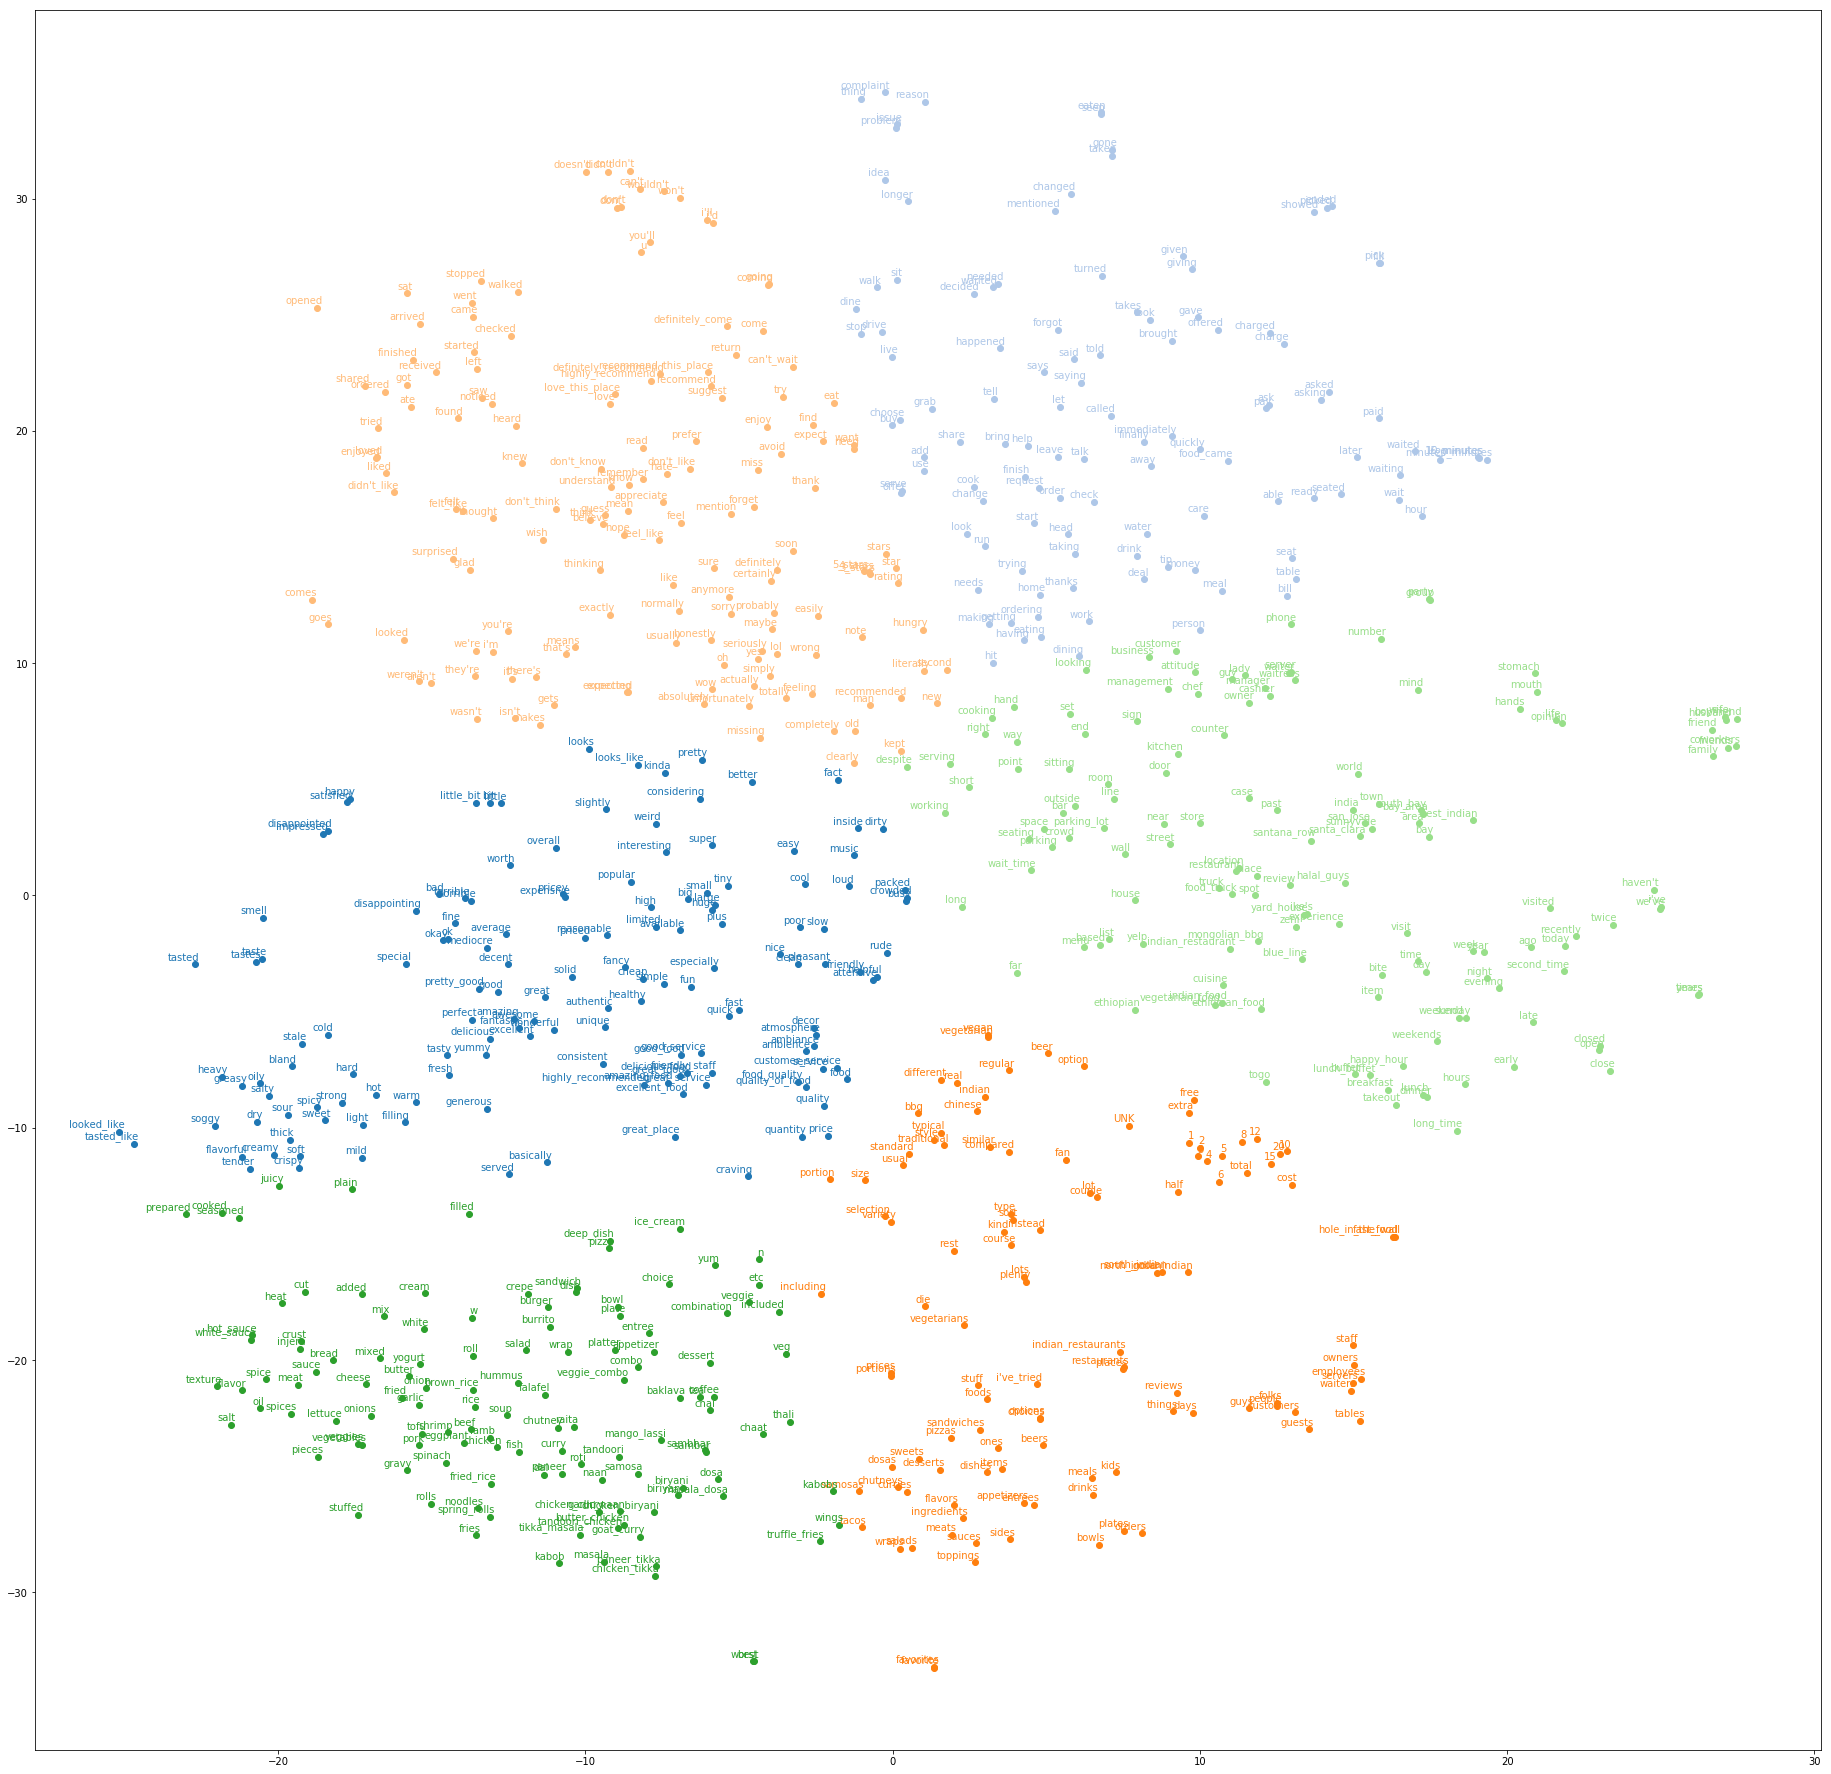

In [10]:
#clustering 1000 words from the embeddings - to see which cluster the dish names belong to
word_labels,x_cord,y_cord=tsne_plot_w_clustering(embeddings,list(word_vocab_dict.items())[0:1000],6)

In [12]:
embeddings.shape

(152344, 50)

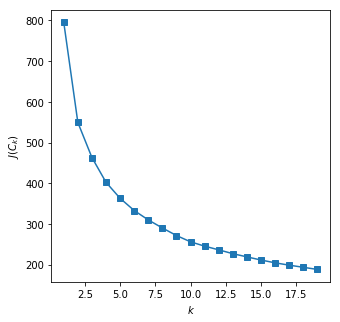

In [14]:
tsne_plot_kmeans_elbow_detection_plot(embeddings,list(word_vocab_dict.items())[0:10000])

In [15]:
num_clusters=10

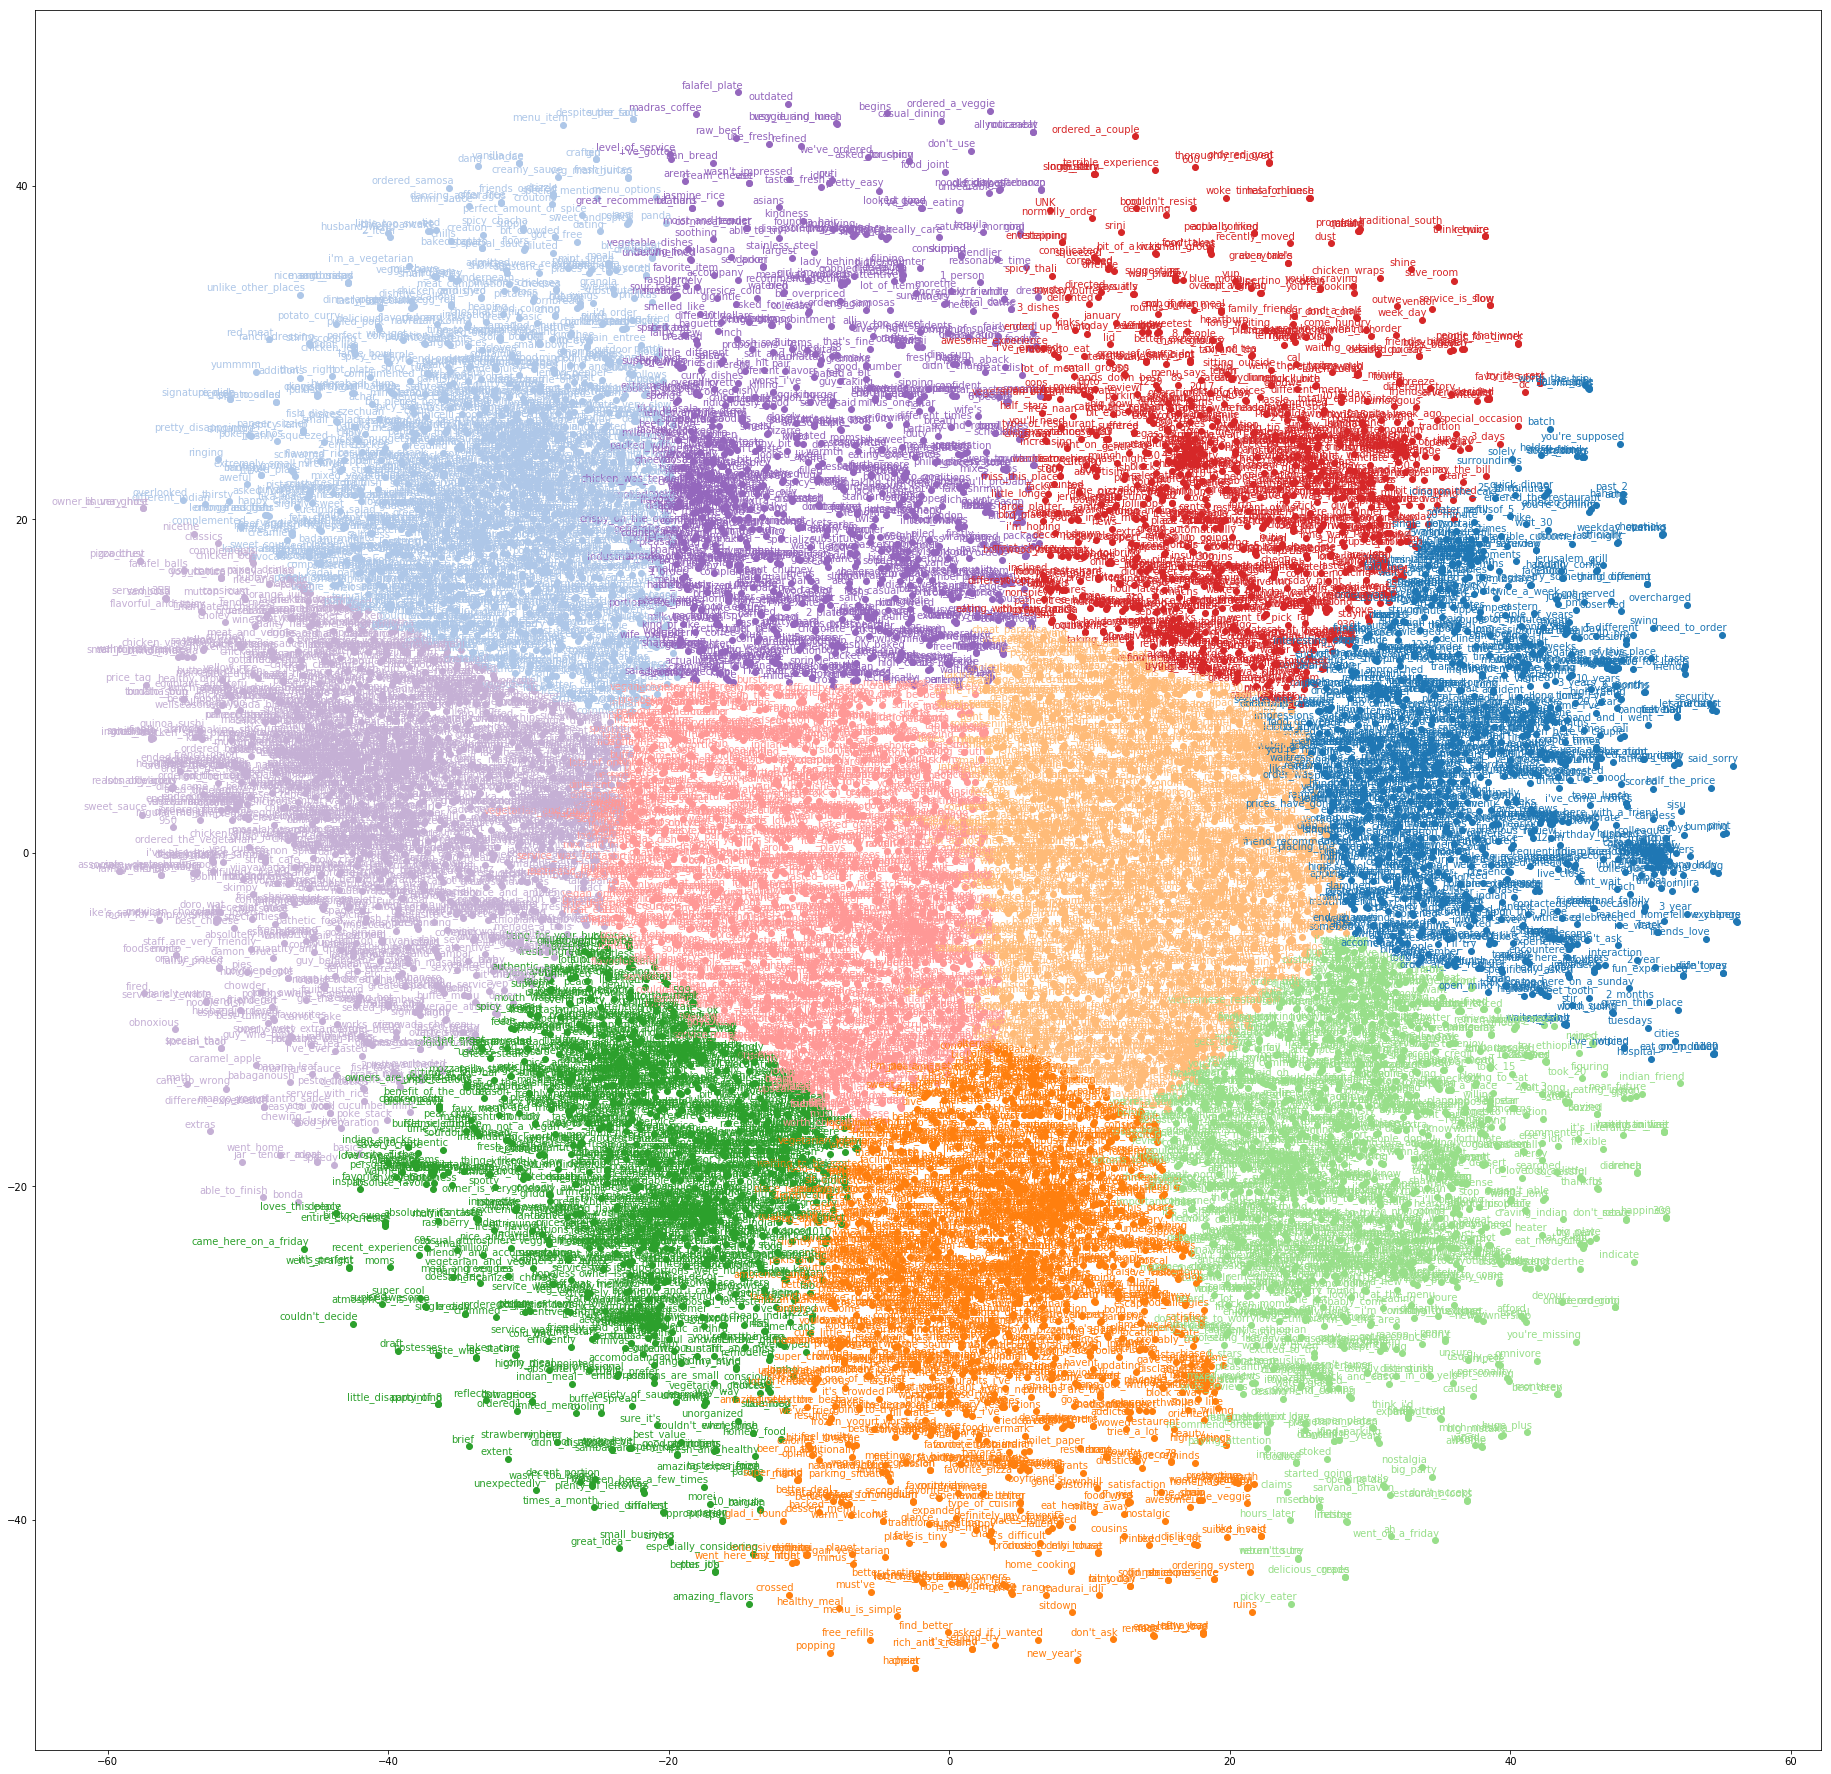

In [16]:
word_labels,x_cord,y_cord=tsne_plot_w_clustering(embeddings,list(word_vocab_dict.items())[0:10000],num_clusters)